In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import cPickle as pickle
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import minkowski

In [3]:

def getVisited():
    visited = []
    f = open(visitedList, 'rb')
    visited = pickle.load(f)
    return visited


def walkLevel1Dir(root):
    count = 0
    dirList = []
    filesList = []
    for path, dirs, files in os.walk(root):
        if count > 0:
            return dirList , fileList
        dirList = dirs
        fileList = files
        count = count + 1


def getPopularFile(rootDir):
    f = open(rootDir + '/popular.json' ,'r')
    data = json.load(f)
    return data

    
    
def getPopularPosts(popular , loopThreshold):
    records = popular['data']['records']
    posts=[]
    for i in range (0 , len(records)):
        loopCount = records[i]['reposts']['count']
        if(loopCount > loopThreshold):
            posts.append(records[i])
    return posts

def getRecords(popular):
    records = popular['data']['records']
    return records

def find(lst, val):
    return [i for i, x in enumerate(lst) if x == val]

def ProbeClusters(senti_matrix):
    centroid_list = []
    id_list = []
    for i in range(1 , 10):
        centroids,_ = kmeans(senti_matrix,i)
        idx,_ = vq(senti_matrix,centroids)
        centroid_list.append(centroids)
        id_list.append(idx)

    SSE_values = np.zeros(len(id_list))
    for i in range(len(centroid_list)):
        for j in range(len(centroid_list[i])):
            vecs = senti_matrix[id_list==j,:]
            cent = centroid_list[i][j]
            SSE_1 = 0.0
            for vec in vecs:
                SSE_1 = SSE_1 + minkowski(vec,cent,2)
            SSE_values[j] = SSE_values[j] + (SSE_1/len(vecs))
    return SSE_values

In [4]:
ClassFile = "../Logs/classes.json"

vineScores = "../Logs/vineSentibankProbs.csv"
selfieScores = "../Logs/selfieSentibankProbs.csv"

vinePaths = "../Logs/vinePaths.txt"
selfiePaths = "../Logs/selfiePaths.txt"

selfiePopularityFile = "../Logs/selfie_dataset.txt"

root = "../vinedata/Data/"

visitedList = "../Logs/facesExtracted.data"

In [5]:
#Load the Sentibank scores for both selfies and Vines
vineProbs = np.loadtxt(vineScores, delimiter=',')
selfieProbs = np.loadtxt(selfieScores, delimiter=',')



In [6]:
vineProbs.shape
print vineProbs[10].argsort()
print vineProbs[10].argmax()

[ 390  793  502 ...,   57  212 1322]
1322


In [7]:
vineTop10 = np.zeros((vineProbs.shape[0],10))
for i in range(vineProbs.shape[0]):
    vineTop10[i] =  vineProbs[i].argsort()[-10:][::-1]

In [8]:
print vineTop10[10]

[ 1322.   212.    57.   983.   435.  1024.   175.  1325.   434.   929.]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


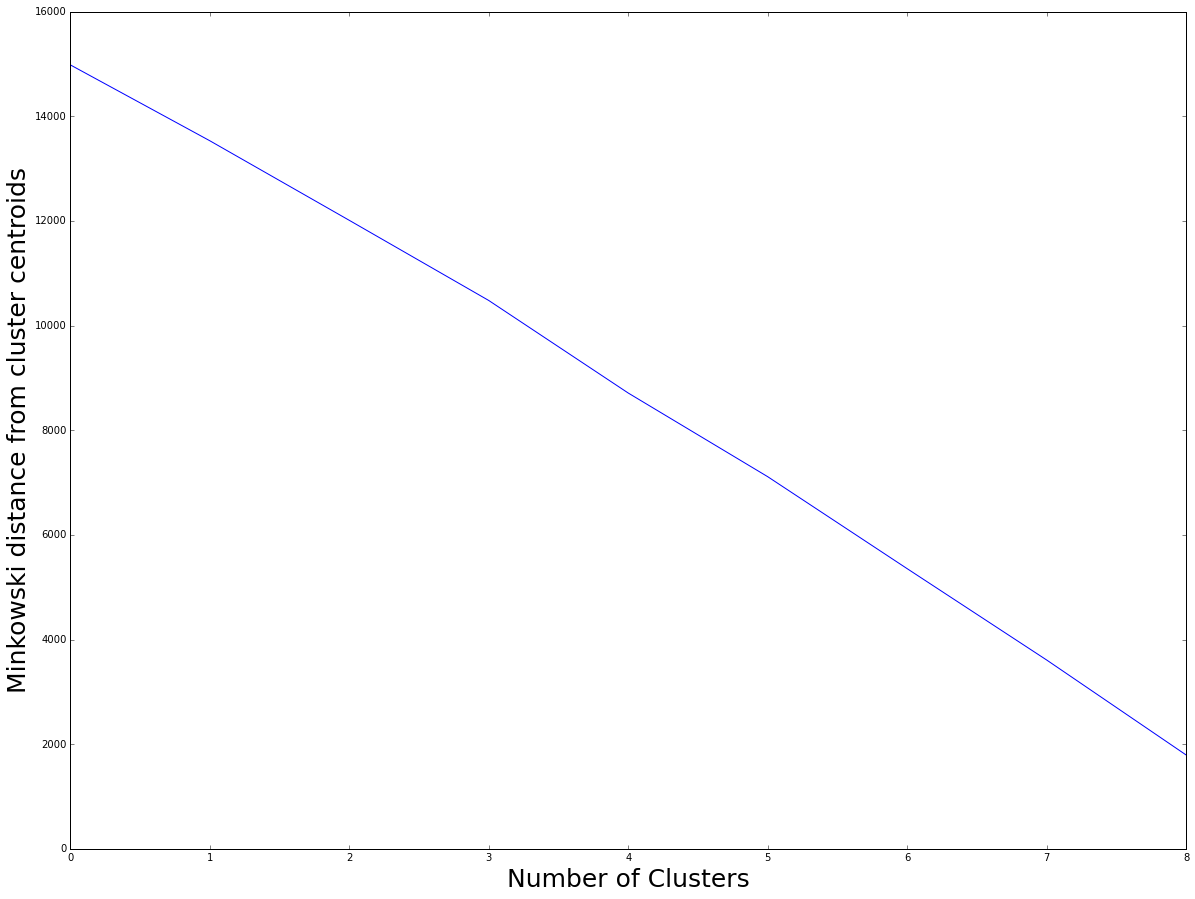

In [9]:
vine_clusters = ProbeClusters(vineTop10)
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.plot(vine_clusters)
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Minkowski distance from cluster centroids", fontsize = 25)
plt.show()

In [10]:
f = open(ClassFile ,'r')
sentibankClasses = json.load(f)
f.close()

with open(vinePaths) as g:
    vineList = g.readlines()
    
with open(selfiePaths) as g:
    selfieList = g.readlines()
    
with open(selfiePopularityFile) as g:
    selfieNumbers = g.readlines()

In [11]:

dirs,files = walkLevel1Dir(root)
visited = getVisited()
selectedPosts = []
allPosts = []


for d in dirs:
    if d in visited:
        dataRoot = root + d
        popular = getPopularFile(dataRoot)
        rec = getRecords(popular)
        allPosts += rec

In [12]:
postIds = []
for line in vineList:
    arr = line.split('/')
    i = int(arr[5].split('_')[0])
    postIds.append(i)

In [13]:
totalPosts = []
likeCount = np.zeros((len(postIds)) , dtype='float')
repostCount = np.zeros((len(postIds)) , dtype='float')
loopCount = np.zeros((len(postIds)) , dtype='float')
for post in allPosts:
    totalPosts.append(int(post['postId']))
    indices = find(postIds , int(post['postId']))
    for i in indices:
        likeCount[i] = int(post['likes']['count'])
        repostCount[i] = int(post['reposts']['count'])
        loopCount[i] = int(post['loops']['count'])


In [20]:

print np.corrcoef(repostCount,loopCount)
print np.corrcoef(likeCount,loopCount)
print np.corrcoef(repostCount,likeCount)

[[ 1.          0.71409929]
 [ 0.71409929  1.        ]]
[[ 1.          0.79104569]
 [ 0.79104569  1.        ]]
[[ 1.          0.94168375]
 [ 0.94168375  1.        ]]


In [22]:
print likeCount.shape

(18585,)


In [ ]:
selfieIDs = []
for line in selfieList:
    arr = line.split('/')
    i = arr[6].split('.')[0]
    selfieIDs.append(i)
print selfieIDs[100]

In [ ]:
IDs = []
popScore = []
for line in selfieNumbers:
    arr = line.split(' ')
    IDs.append(arr[0])
    popScore.append(float(arr[1]))

In [ ]:
matchedScore = np.zeros((len(selfieIDs)))
for i in range(len(selfieIDs)):
    index = IDs.index(selfieIDs[i])
    matchedScore[i] = popScore[index] 

In [ ]:
print matchedScore.shape
print matchedScore.max(), matchedScore.min()

In [ ]:
norm_factor = matchedScore.max()
likeScaleBackDeno = likeCount.max()
likeCount /= likeScaleBackDeno
likeCount *= norm_factor
print likeCount.max(),likeCount.min()

In [ ]:
repostScaleBackdeno = repostCount.max()
repostCount /= repostScaleBackdeno
repostCount *= norm_factor
print repostCount.max(),repostCount.min()

In [ ]:
likeScaleBackDeno = likeScaleBackDeno/norm_factor
repostScaleBackdeno = repostScaleBackdeno/norm_factor
print likeScaleBackDeno, repostScaleBackdeno 

In [ ]:
print vineProbs.shape
print selfieProbs.shape

In [ ]:
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

In [ ]:
#lin_clf_vine = RandomForestClassifier(n_estimators=vineProbs.shape[1])
#lin_clf_selfie = RandomForestClassifier(n_estimators=selfieProbs.shape[1])
np.random.seed(0)
lin_clf_vine_repost = svm.LinearSVR(C=1.0, epsilon=0.2 )
lin_clf_vine_like = svm.LinearSVR(C=1.0, epsilon=0.2 )
lin_clf_selfie = svm.LinearSVR(C=1.0, epsilon=0.2 )

In [ ]:

X_train_vine = vineProbs[:15000]
X_test_vine = vineProbs[15000:]

# Y_train_vine = likeCount[:15000]
# Y_test_vine = likeCount[15000:]

Y_train_vine_repost = repostCount[:15000]
Y_test_vine_repost = repostCount[15000:]

Y_train_vine_like = likeCount[:15000]
Y_test_vine_like = likeCount[15000:]


In [ ]:
lin_clf_vine_repost.fit(X_train_vine, Y_train_vine_repost)
lin_clf_vine_like.fit(X_train_vine, Y_train_vine_like)

In [ ]:
pred_repost = lin_clf_vine_repost.predict(X_test_vine)
print mean_squared_error(Y_test_vine_repost, pred_repost)
print mean_absolute_error(Y_test_vine_repost, pred_repost)
np.corrcoef(Y_test_vine_repost, pred_repost)


In [ ]:
pred_likes = lin_clf_vine_like.predict(X_test_vine)
print mean_squared_error(Y_test_vine_like, pred_likes)
print mean_absolute_error(Y_test_vine_like, pred_likes)
np.corrcoef(Y_test_vine_like, pred_likes)

Selfie Regression

In [ ]:
X_train_selfie = selfieProbs[:40000]
X_test_selfie = selfieProbs[40000:]

Y_train_selfie = matchedScore[:40000]
Y_test_selfie = matchedScore[40000:]

In [ ]:
lin_clf_selfie.fit(X_train_selfie,Y_train_selfie)

In [ ]:

pred_pop = lin_clf_selfie.predict(X_test_selfie)
print mean_squared_error(Y_test_selfie, pred_pop)
print mean_absolute_error(Y_test_selfie, pred_pop)
np.corrcoef(Y_test_selfie, pred_pop)

In [ ]:
# #USE VINE FOR SELFIE
# pred_pop = lin_clf_vine_like.predict(X_test_selfie)
# print mean_squared_error(Y_test_selfie, pred_pop)
# print mean_absolute_error(Y_test_selfie, pred_pop)
# np.corrcoef(Y_test_selfie, pred_pop)

In [ ]:
# #USE SELFIE FOR VINE
# pred_repost = lin_clf_selfie.predict(X_test_vine)
# print mean_squared_error(Y_test_vine, pred_repost)
# print mean_absolute_error(Y_test_vine, pred_repost)
# np.corrcoef(Y_test_vine, pred_repost)

In [ ]:

coef_indices_vine_repost = lin_clf_vine_repost.coef_.argsort()[::-1][:lin_clf_vine_repost.coef_.shape[0]]
coef_values_vine_repost = np.zeros(coef_indices_vine_repost.shape[0])
coef_values_vine_repost = lin_clf_vine_repost.coef_[coef_indices_vine_repost]
coef_labels_vine_repost = []
for i in range(100):
    coef_labels_vine_repost.append(sentibankClasses[coef_indices_vine_repost[i]])


In [ ]:
coef_indices_vine_like = lin_clf_vine_like.coef_.argsort()[::-1][:lin_clf_vine_repost.coef_.shape[0]]
coef_values_vine_like = np.zeros(coef_indices_vine_like.shape[0])
coef_values_vine_like = lin_clf_vine_like.coef_[coef_indices_vine_like]
coef_labels_vine_like = []
for i in range(100):
    coef_labels_vine_like.append(sentibankClasses[coef_indices_vine_like[i]])


In [ ]:
coef_indices_selfie = lin_clf_selfie.coef_.argsort()[::-1][:lin_clf_vine_repost.coef_.shape[0]]
coef_values_selfie = np.zeros(coef_indices_selfie.shape[0])
coef_values_selfie = lin_clf_selfie.coef_[coef_indices_selfie]
coef_labels_selfie = []
for i in range(100):
    coef_labels_selfie.append(sentibankClasses[int(coef_indices_selfie[i])])


In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.linspace(0,10,10)
i = 0
for m,n in zip(x, coef_values_vine_repost[:10]):                                       # <--
    ax.annotate(coef_labels_vine_repost[i],(m,n),fontsize = 20)
    i+=1

i = 0

for m,n in zip(x, coef_values_vine_like[:10]):                                       # <--
    ax.annotate(coef_labels_vine_like[i],(m,n),fontsize = 20)
    i+=1
    
i = 0
for m,n in zip(x, coef_values_selfie[:10]):                                       # <--
    ax.annotate(coef_labels_selfie[i],(m,n),fontsize = 20)
    i+=1
    
plt.plot(x,coef_values_vine_repost[:10],'^b',markersize=20.0)
plt.plot(x,coef_values_vine_like[:10],'og',markersize=20.0)
plt.plot(x,coef_values_selfie[:10],'*r',markersize=20.0)

plt.title("Support vector Regression Coeffiecient comparison",fontsize = 25)

plt.xlabel('Coefficient indices',fontsize = 25)
plt.ylabel('Coefficient values (sorted)', fontsize = 25)

plt.legend(['Vine Regression Coefficient for Reposts','Vine Regression Coefficient for Likes','Selfie Regression coefficients'],fontsize = 20)

plt.show()

Till this point we know that vine and instagram video selfies are fundamentally different. Instagran selfies have more positive sentiments. 

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000)
svd.fit(vineProbs) 
print(svd.explained_variance_ratio_.sum()) 

In [ ]:
reduced_feats = svd.fit_transform(vineProbs)

In [ ]:
likeCount = np.zeros((len(postIds)) , dtype='float')
repostCount = np.zeros((len(postIds)) , dtype='float')
for post in allPosts:
    indices = find(postIds , int(post['postId']))
    for i in indices:
        likeCount[i] = int(post['likes']['count'])
        repostCount[i] = int(post['reposts']['count'])


In [ ]:
print likeCount.max(), repostCount.max()

In [ ]:
factors = np.logspace(0, 1, 29 , endpoint = True)
factors /= 40
repostIndices = []
for i in factors:
    repostIndices.append(int(i*30000))

print factors
print repostIndices

In [ ]:
classesRepost = np.zeros((repostCount.shape[0],30) , dtype = 'int')
for i in range(repostCount.shape[0]):
    for j in range(29):
        index = 100
        if repostCount[i] < repostIndices[j]:
            index = j
    if index == 100:
            index = 29
    classesRepost[i][index] = 1

In [ ]:
factors = np.logspace(0, 1, 19 , endpoint = True)
factors /= 40
likesIndices = []
for i in factors:
    likesIndices.append(int(i*100000))

print factors
print likesIndices

In [ ]:
classesLike = np.zeros((likeCount.shape[0],20) , dtype = 'int')
for i in range(likeCount.shape[0]):
    for j in range(19):
        index = 100
        if likeCount[i] < likesIndices[j]:
            index = j
    if index == 100:
            index = 19
    classesLike[i][index] = 1

In [ ]:
# classWidthLikes = 5000
# classWidthRepost = 1000

# LikeClasses = 100000/classWidthLikes
# RepostClasses = 30000/classWidthRepost
# print LikeClasses, RepostClasses

In [ ]:
# classesLike = np.zeros((likeCount.shape[0],LikeClasses) ,  dtype = 'int')
# classesRepost = np.zeros((repostCount.shape[0],RepostClasses) , dtype = 'int')

In [ ]:
# for i in range(likeCount.shape[0]):
#     index = int((likeCount[i]/classWidthLikes))
#     classesLike[i][index-1] = 1

In [ ]:
# for i in range(repostCount.shape[0]):
#     index = int((repostCount[i]/classWidthRepost))
#     classesRepost[i][index-1] = 1

In [ ]:
print classesLike.shape

In [ ]:
likes_training = classesLike[:15000]
likes_validate = classesLike[15000:]

reposts_training = classesRepost[:15000]
reposts_validate = classesRepost[15000:]

features_training = reduced_feats[:15000]
features_validate = reduced_feats[15000:]

In [ ]:
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import sys
import os
import pickle
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
from six.moves import cPickle


In [ ]:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    W = theano.shared(floatX(np.random.randn(*shape) * 0.01))
    return W

def init_bias(shape):
    b_values = np.zeros((shape[0],), dtype=theano.config.floatX)
    b = theano.shared(value=b_values, borrow=True )
    return b

def rectify(X):
    return T.maximum(X, 0.)

def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X = X *  srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X = (X/retain_prob)
    return X

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def negative_log_likelihood(p_y_given_x,y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}
                \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
            \ell (\theta=\{W,b\}, \mathcal{D})

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        # start-snippet-2
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
    
def saveModel(i):
    snapshot = modelDir + "SentibankVinePredictor_likes_lognormal" + str(i) +".model"    
    mfile = open(snapshot, 'wb')
    cPickle.dump(params, mfile, protocol=cPickle.HIGHEST_PROTOCOL)
    mfile.close()


In [ ]:
def model(X, w0, b0, w1, b1, w2, b2, w_o, b_o, p_drop_conv, p_drop_hidden):

    l0 = rectify(T.dot(X, w0) + b0.dimshuffle('x', 0 ))
    l0 = dropout(l0, p_drop_hidden)
    
    l1 = rectify(T.dot(l0, w1) + b1.dimshuffle('x', 0 ))
    l1 = dropout(l1, p_drop_hidden)
    
    l2 = rectify(T.dot(l1, w2) + b2.dimshuffle('x', 0))
    l2 = dropout(l2, p_drop_hidden)

    pyx = T.nnet.softmax(T.dot(l2, w_o) + b_o.dimshuffle('x', 0))
    #opVec = T.dot(l2, w_o) + b_o.dimshuffle('x', 0)
    #ydev = opVec-opVec.max(1,keepdims=True)
    #pyx = ydev - T.log(T.sum(T.exp(ydev),axis=1,keepdims=True))
    return l0, l1, l2, pyx


In [ ]:
w0 = init_weights((1000, 1000)) 
b0 = init_bias((1000,1))

w1 = init_weights((1000, 10000)) 
b1 = init_bias((10000 , 1))

w2 = init_weights((10000, 1000)) 
b2 = init_bias((1000 , 1))

w_o = init_weights((1000, 20))
b_o = init_bias((20,1))

# w_o = init_weights((1000, 30))
# b_o = init_bias((30,1))


In [ ]:
learning_rate = 0.005
batch_size = 60

X = T.fmatrix()
Y = T.imatrix()

noise_10 , noise_l1, noise_l2, noise_py_x = model(X, w0, b0, w1, b1, w2, b2, w_o, b_o, 0.2, 0.5)

params = [ w0, b0, w1, b1, w2, b2, w_o, b_o ]

#yvec = argmax(noise_py_x,axis=1)
cost = T.nnet.categorical_crossentropy(noise_py_x, Y).mean()
#cost = negative_log_likelihood(noise_py_x , Y)
#cost = T.nnet.binary_crossentropy(noise_py_x, Y).mean()

#stabler Cross Entropy

#cost = -T.sum(Y*noise_py_x,axis=1).mean()

updates = RMSprop(cost, params, lr=0.0009)

grads = T.grad(cost, params)
#updates = [ (param_i, param_i - learning_rate * grad_i) for param_i, grad_i in zip(params, grads)]
    

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)

#Predict Loop
l0, l1, l2, py_x = model(X, w0, b0, w1, b1, w2, b2, w_o, b_o, 0., 0.)
y_x = T.argmax(py_x, axis=1)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

In [ ]:
from sklearn import cross_validation
from sklearn.cross_validation import KFold
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(reduced_feats, yLabels, test_size=0.2, random_state=0)
kf = KFold(features_training.shape[0], n_folds=2)

In [ ]:
logPickle = "../Logs/LikesPredictionTraining_lognormal.pk"
modelDir = "../Models/"

In [ ]:
oldError = 0.
startError = 0.
iterStart = 0
iterEnd = 150
for train_index, test_index in kf:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features_training[train_index], features_training[test_index]
    y_train, y_test = likes_training[train_index], likes_training[test_index]
    #y_train, y_test = reposts_training[train_index], reposts_training[test_index]

    for i in range(iterStart,iterEnd):
        for start, end in zip(range(0, len(X_train), batch_size), range(batch_size, len(X_train), batch_size)):
            cost = train(X_train[start:end], y_train[start:end])
        error = np.mean(np.argmax(y_test,axis=1) == predict(X_test))

        if(i == iterStart):
            oldError = error
            startError = error

        delta = ((error - oldError)/oldError)*100
        improvement = ((startError - error)/startError)*100

        if (delta > 2 or (i%100 == 0)):
            saveModel(i)
        if (improvement > 1.0):
            saveModel(i)
            startError = error

        logline = "Epoch: " + str(i) + "  Accuracy: " + str(error) + " Cost: " + str(cost)
        print logline
        f = open(logPickle, 'a+')
        cPickle.dump(logline , f);
        f.close()
        oldError = error

In [ ]:
# validate_error = np.mean(np.argmax(reposts_validate,axis=1) == predict(features_validate))
# print "Out of Sample Validating Error %s" + str(validate_error)

In [ ]:
saveModel("final")

In [ ]:
# modelParams = open("../Models/SentibankVinePredictor_repostsfinal.model")
# Params = pickle.load(modelParams)

In [ ]:
#LOAD MODEL
# IP = T.fmatrix()
# l0, l1, l2, py_x = model(IP, Params[0], Params[1], Params[2], Params[3], Params[4], Params[5], Params[6], Params[7], 0., 0.)
# OP = T.argmax(py_x, axis=1)
# predict = theano.function(inputs=[IP], outputs=OP, allow_input_downcast=True)

In [ ]:
validate_error = np.mean(np.argmax(likes_validate,axis=1) == predict(features_validate))
print "Out of Sample Validating Error %s" + str(validate_error)

In [ ]:
from sklearn.metrics import mean_absolute_error
pred = predict(features_validate)
MAE = mean_absolute_error(np.argmax(likes_validate,axis=1), pred)
corr = np.corrcoef(np.argmax(likes_validate,axis=1), pred)
print MAE , corr

In [ ]:
# lists = []
# infile = open('ErrosCNN7LayersV2.pickle', 'r')
# while 1:
#     try:
#         lists.append(pickle.load(infile))
#     except (EOFError):
#         break
# infile.close()

In [ ]:
Count = np.random.exponential(0.15, 15000)
likeCount = np.zeros(len(Count))
for i in range(len(Count)):
    likeCount[i] = Count[i] * 100000
classesLike = np.zeros((likeCount.shape[0],20) , dtype = 'int')
for i in range(likeCount.shape[0]):
    for j in range(19):
        index = 100
        if likeCount[i] < likesIndices[j]:
            index = j
    if index == 100:
        index = 19
    classesLike[i][index] = 1
for count in range(100):
    np.random.shuffle(classesLike)
    np.random.shuffle(likes_training)
    error = np.mean(np.argmax(classesLike,axis=1) == np.argmax(likes_training,axis=1))
    MAE = mean_absolute_error(np.argmax(classesLike,axis=1), np.argmax(likes_training,axis=1))
    corr = np.corrcoef(np.argmax(classesLike,axis=1), np.argmax(likes_training,axis=1))
    print error , MAE , corr

In [ ]:
Count = np.random.exponential(0.15, 15000)
repostCount = np.zeros(len(Count))
for i in range(len(Count)):
    repostCount[i] = Count[i] * 30000

In [ ]:
print repostCount[0]

In [ ]:

repostLike = np.zeros((likeCount.shape[0],30) , dtype = 'int')
for i in range(repostCount.shape[0]):
    for j in range(29):
        index = 100
        if repostCount[i] < repostIndices[j]:
            index = j
    if index == 100:
        index = 29
    repostLike[i][index] = 1
for count in range(100):
    np.random.shuffle(repostLike)
    #np.random.shuffle(reposts_training)
    error = np.mean(np.argmax(repostLike,axis=1) == np.argmax(reposts_training,axis=1))
    MAE = mean_absolute_error(np.argmax(repostLike,axis=1), np.argmax(reposts_training,axis=1))
    corr = np.corrcoef(np.argmax(repostLike,axis=1), np.argmax(reposts_training,axis=1))
    print error , MAE , corr